In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pathlib
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torchvision.models import ResNet18_Weights


# mean = np.array([0.5, 0.5, 0.5])
# std = np.array([0.25, 0.25, 0.25])

#training_set = ImageFolder("Task2_dataset//training")
# data_dir = 'Task2_dataset/training'
# image_datasets = {x: datasets.ImageFolder(os.path.join(
#     data_dir, x), data_transforms[x]) for x in ['training', 'testing']}
# dataloaders = {x: torch.utils.data.DataLoader(
#     image_datasets[x], batch_size=4, shuffle=True, num_workers=0) for x in ['training', 'testing']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'testing']}
# class_names = image_datasets['training'].classes
# print(class_names)

transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
training_set = ImageFolder("Task2_dataset//training", transform=transform)
val_size = 120
train_size = len(training_set) - val_size
train_ds, val_ds = random_split(training_set, [train_size, val_size])
len(train_ds), len(val_ds)
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=4, shuffle=True, num_workers=0)
root = pathlib.Path("Task2_dataset//training")
class_names = sorted([j.name.split('/')[-1] for j in root.iterdir()])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is set to", device)
print(class_names)
print(train_loader)


Device is set to cpu
['Combat', 'DestroyedBuildings', 'Fire', 'Humanitarian Aid and rehabilitation', 'Military vehicles and weapons']


In [11]:
def plot_losses(loss_values, epoch, n_epochs):
    x0 = list(range(1, epoch+1))
    plt.figure(figsize=(5, 2))
    plt.plot(x0, loss_values)
    plt.title('Model loss')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


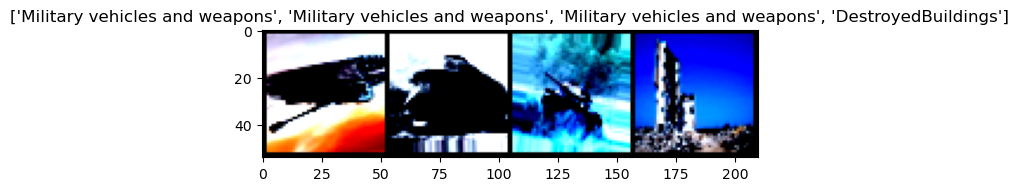

In [12]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
                epoch_loss = running_loss / train_size
                epoch_acc = running_corrects.double() / train_size
            else:
                epoch_loss = running_loss / val_size
                epoch_acc = running_corrects.double() / val_size
            # if phase == 'train':
            #     scheduler.step()
            #     epoch_loss = loss
            #     epoch_acc = 1- loss
            # else:
            #     epoch_loss = running_loss / val_size
            #     epoch_acc = running_corrects.double() / val_size

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    #plot_losses(epoch_loss, epoch, num_epochs)
    #models[0].show(update_display=True)

    model.load_state_dict(best_model_wts)
    return model


In [14]:

#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.
eps = 10
model = models.resnet18(weights=ResNet18_Weights, progress = True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 5)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()


step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=eps)


#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(weights=ResNet18_Weights, progress = True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 5)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=eps)
torch.save(model, 'model_conv_2c.pth')


/home/srikar/miniconda3/envs/GG_1240/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/9
----------
train Loss: 0.7993 Acc: 0.7666
val Loss: 11.5986 Acc: 15.4500

Epoch 1/9
----------
train Loss: 0.6158 Acc: 0.8300
val Loss: 7.8035 Acc: 16.1833

Epoch 2/9
----------
train Loss: 0.4729 Acc: 0.8593
val Loss: 5.6797 Acc: 16.6667

Epoch 3/9
----------
train Loss: 0.3882 Acc: 0.8746
val Loss: 4.5628 Acc: 16.7083

Epoch 4/9
----------
train Loss: 0.3914 Acc: 0.8768
val Loss: 5.7141 Acc: 16.6917

Epoch 5/9
----------
train Loss: 0.3582 Acc: 0.8862
val Loss: 4.7835 Acc: 16.9167

Epoch 6/9
----------
train Loss: 0.3130 Acc: 0.8898
val Loss: 5.1943 Acc: 17.0833

Epoch 7/9
----------
train Loss: 0.2689 Acc: 0.9011
val Loss: 5.7516 Acc: 16.6250

Epoch 8/9
----------
train Loss: 0.2435 Acc: 0.9200
val Loss: 4.2964 Acc: 17.1417

Epoch 9/9
----------
train Loss: 0.2460 Acc: 0.9209
val Loss: 2.6552 Acc: 17.4250

Training complete in 32m 17s
Best val Acc: 17.425000
Epoch 0/9
----------
train Loss: 0.7794 Acc: 0.7415
val Loss: 11.5931 Acc: 14.6500

Epoch 1/9
----------
train Loss:

In [4]:
from PIL import Image
from torch.autograd import Variable
import pandas as pd

test_data = ["building1", "building2", "combat1", "combat2",
             "fire1", "fire2", "military1", "military2", "rehab1", "rehab2"]


def prediction(transformer):
    headers = ["Acutal Image Name", "   Output Image Name"]
    data = []
    for img in test_data:
        img_path = "/mnt/Storage Drive/Projects/E-YRC/EYRC_2023/Task 2/Task 2C/Task2_dataset/testing/"+img+".jpeg"
        image = Image.open(img_path)
        image_tensor = transformer(image).float()
        image_tensor = image_tensor.unsqueeze_(0)
        # input = Variable(image_tensor)
        output = model_conv(image_tensor)
        index = output.data.numpy().argmax()
        pred = class_names[index]
        data.append([img, pred])
    print(pd.DataFrame(data, columns=headers))

prediction(transform)


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/Storage Drive/Projects/E-YRC/EYRC_2023/Task 2/Task 2C/Task2_dataset/testing/building1.jpeg'

In [13]:
from PIL import Image
from torch.autograd import Variable
import pandas as pd

test_data = ["Img_0", "Img_1", "Img_2", "Img_3","Img_4", "Img_5","Img_6"]


def prediction(transformer):
    headers = ["Acutal Image Name", "   Output Image Name"]
    data = []
    for img in test_data:
        img_path = "/mnt/Storage Drive/Projects/E-YRC/EYRC_2023/Task_4/Task_4A/Saved_Images/"+img+".jpg"
        image = Image.open(img_path)
        image_tensor = transformer(image).float()
        image_tensor = image_tensor.unsqueeze_(0)
        # input = Variable(image_tensor)
        model_conv = torch.load("/mnt/Storage Drive/Projects/E-YRC/EYRC_2023/Task_2/Task_2B/model_conv (1).pth")
        output = model_conv(image_tensor)
        index = output.data.numpy().argmax()
        pred = class_names[index]
        data.append([img, pred])
    print(pd.DataFrame(data, columns=headers))

prediction(transform)


  Acutal Image Name                    Output Image Name
0             Img_0                                 Fire
1             Img_1        Military vehicles and weapons
2             Img_2                                 Fire
3             Img_3  Humanitarian Aid and rehabilitation
4             Img_4                   DestroyedBuildings
5             Img_5                               Combat
6             Img_6  Humanitarian Aid and rehabilitation


In [1]:
#Import the necessary libraries 
import cv2 
import matplotlib.pyplot as plt 
import numpy as np 
  
# Load the image 
image = cv2.imread('/mnt/Storage Drive/Downloads/WhatsApp Image 2023-12-03 at 7.46.46 PM.jpeg') 
  
#Plot the original image 
# plt.subplot(1, 2, 1) 
# plt.title("Original") 
# plt.imshow(image) 
  
# Create the sharpening kernel 
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) 
  
# Sharpen the image 
sharpened_image = cv2.filter2D(image, -1, kernel) 
  
#Save the image 
cv2.imwrite('sharpened_image.jpg', sharpened_image) 
  
#Plot the sharpened image 
# plt.subplot(1, 2, 2) 
# plt.title("Sharpening") 
# plt.imshow(sharpened_image) 
# plt.show()
cv2.imshow("Original", image)
cv2.imshow("Sharpening", sharpened_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

[ WARN:0@0.501] global loadsave.cpp:248 findDecoder imread_('/mnt/Storage Drive/Downloads/WhatsApp Image 2023-12-03 at 7.46.46 PM.jpeg'): can't open/read file: check file path/integrity


error: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/filter.dispatch.cpp:1530: error: (-215:Assertion failed) !_src.empty() in function 'filter2D'
